# Crecimiento monetario

Este notebook tiene los siguientes objetivos:
- Mostrar las diferencias en el crecimiento de la cantidad de dinero en diferentes economías.
- Establecer una relación entre crecimiento de la cantidad de dinero, la velocidad del dinero y la inflación


## Diferencias en cantidad de dinero

Se estudiarán las siguientes áreas monetarias: los Estados Unidos, la Unión Europea, Suiza, el Reino Unido y Japón.

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from utils import get_snb_data, get_ecb_data
import pandas as pd

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

In [43]:
df = pd.DataFrame()
df['US'] = pd.read_csv('data/m3-us.csv', sep=';', parse_dates=['Date'], index_col='Date')

df['CH'] = get_snb_data("snbmonagg", {'dimSel': 'D0(B),D1(GM3)',
                                      'fromDate': '1980-01',
                                      })['Value']
df['EU'] = get_ecb_data('BSI',
                        'M.U2.N.V.M30.X.1.U2.2300.Z01.E',
                        )
df['JP'] = pd.read_csv('data/m3-jp.csv', skiprows=3,
                       names=['Date', 'Value'], parse_dates=['Date'], index_col='Date')


/var/folders/q8/gp6z9yks6ynf_34chydw0yrr0000gn/T/ipykernel_71750/1743329449.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['JP'] = pd.read_csv('data/m3-jp.csv', skiprows=3,


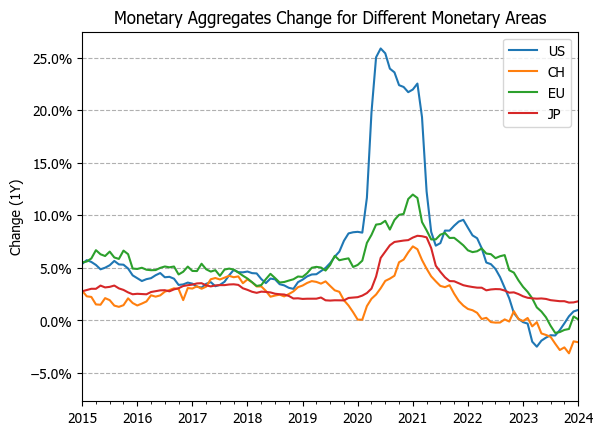

In [48]:
fig, ax = plt.subplots()

df.pct_change(periods=12).plot(ax=ax, label='a')
ax.set_xlim(['2015', '2024'])

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')  #  or bothdd
ax.set_xlabel('')
ax.set_ylabel('Change (1Y)')
ax.set_title('Monetary Aggregates Change for Different Monetary Areas');